# Readme
The purpose of this ipynb file is to clean the textual notes before running topic modelling.

- Input: csv files titled 'df_deid_10000_notes_harris' & 'RQ3_patient_scoring_final'
- Output: NIL 

---

# Importing


In [ ]:
# Pip install relevant libraries
!pip install spacy
!pip install scispacy
!pip install negspacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_scibert-0.5.1.tar.gz
!pip install spacy-transformers
!pip install pyLDAvis
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

In [ ]:
# importing libraries and packages
import spacy_transformers
import re 
import string 
import os
import os.path
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import scispacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
from negspacy.negation import Negex
from negspacy.termsets import termset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import OrdinalEncoder
import pyLDAvis
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim import matutils, models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Import swifter that tries to efficiently apply any function to a df in the quickest available method
import swifter
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/lates

In [ ]:
# mount google drive for google colab
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


# Read Dataset


In [ ]:
path = '/content/drive/MyDrive/{}'
if not os.path.exists(path):
    path = '/content/drive/MyDrive/{}'

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
raw = pd.read_csv('{}RQ3/df_deid_10000_notes_harris.csv'.format(path), index_col = 0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Preprocessing

In [ ]:
# creating a new df with only the person_ids and clinical notes
df = raw[['holmusk_patientid', 'full_note_body']].copy()

# keeping only those rows that are not NaN
df = df[df['holmusk_patientid'].notna()]

# keeping only those rows have more than 100 characters
df = df[df["full_note_body"].str.len() > 100]

# reset the index row numbers
df.reset_index(drop=True,inplace=True)

# show number of unique notes in df
df["full_note_body"].nunique()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7682

In [ ]:
# mapping holmusk patient ids to person ids
df['person_id'] = df['holmusk_patientid'].apply(lambda x: x*10000+31)

# Remove mapped column
df.drop(columns=['holmusk_patientid'],inplace = True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-9e661eec6bc2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['person_id'] = df['holmusk_patientid'].apply(lambda x: x*10000+31)
<ipython-input-8-9e661eec6bc2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [ ]:
# converting person_id into int (easier to read and use)
df['person_id'] = df['person_id'].apply(np.int64)

# rename 'full_note_body' to 'raw_notes' 
df.rename(columns = {'full_note_body':'raw_notes'}, inplace = True)

# converting 'raw_notes' into str
df["raw_notes"] = df["raw_notes"].astype("string")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-998801e6a2f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['person_id'] = df['person_id'].apply(np.int64)
<ipython-input-9-998801e6a2f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.re

In [ ]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 7725 entries, 0 to 7724
# Data columns (total 2 columns):
#  #   Column     Non-Null Count  Dtype 
# ---  ------     --------------  ----- 
#  0   raw_notes  7725 non-null   string
#  1   person_id  7725 non-null   int64 
# dtypes: int64(1), string(1)
# memory usage: 120.8 KB

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7725 entries, 0 to 7724
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_notes  7725 non-null   string
 1   person_id  7725 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 120.8 KB


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,raw_notes,person_id
0,Chief Complaint: No chief complaint on file. ...,4943400031
1,Chief Complaint: depression/anxiety History O...,4959810031
2,Chief Complaint: Chief Complaint Patient pre...,4985060031
3,Chief Complaint: No chief complaint on file. I...,4042600031
4,Chief Complaint: Chief Complaint Patient pre...,4402970031


# Cleaning


In [ ]:
# create lemmatizer
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def text_cleaner(text):
    text_list = text.split()
    result = ""
    for word in text_list:
        # coverting text to lowercase
        word = word.lower()
        # remove numbers
        word = re.sub('\w*\d\w*', '', word)
        # remove all words in '[]'
        word = re.sub("[\[].*?[\]]", "", word)
        # remove punctuation
        # word = re.sub('[%s]' % re.escape(string.punctuation), '', word)
        # lemmetization
        word = wnl.lemmatize(word)
        if word != "":
          result += word.strip() + " "
    return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \w
<>:13: DeprecationWarning: invalid escape sequence \[
<>:11: DeprecationWarning: invalid escape sequence \w
<>:13: DeprecationWarning: invalid escape sequence \[
<ipython-input-13-6e0c18c838ef>:11: DeprecationWarning: invalid escape sequence \w
  word = re.sub('\w*\d\w*', '', word)
<ipython-input-13-6e0c18c838ef>:13: DeprecationWarning: invalid escape sequence \[
  word = re.sub("[\[].*?[\]]", "", word)


In [ ]:
df["raw_notes_cleaned"] = df["raw_notes"].apply(text_cleaner)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Building Spacy Pipeline

In [ ]:
# using a random clincial note as an example to check effectivenes of negation 
example = df["raw_notes_cleaned"][3]
example

In [ ]:
# checking the current negation terms included in the termset
ts = termset("en_clinical")
print(ts.get_patterns())

{'pseudo_negations': ['no further', 'not able to be', 'not certain if', 'not certain whether', 'not necessarily', 'without any further', 'without difficulty', 'without further', 'might not', 'not only', 'no increase', 'no significant change', 'no change', 'no definite change', 'not extend', 'not cause', 'gram negative', 'not rule out', 'not ruled out', 'not been ruled out', 'not drain', 'no suspicious change', 'no interval change', 'no significant interval change'], 'preceding_negations': ['absence of', 'declined', 'denied', 'denies', 'denying', 'no sign of', 'no signs of', 'not', 'not demonstrate', 'symptoms atypical', 'doubt', 'negative for', 'no', 'versus', 'without', "doesn't", 'doesnt', "don't", 'dont', "didn't", 'didnt', "wasn't", 'wasnt', "weren't", 'werent', "isn't", 'isnt', "aren't", 'arent', 'cannot', "can't", 'cant', "couldn't", 'couldnt', 'never', 'patient was not', 'without indication of', 'without sign of', 'without signs of', 'without any reactions or signs of', 'no comp

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# modify negation patterns in the termset (en_clinical)
ts.add_patterns(
    {
        "preceding_negations":["denies", "no", "not a problem"],
        "following_negations": ["negative", "none", "not present"]
    }
)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# building spacy pipeline
nlp = spacy.load("en_ner_bc5cdr_md")
nlp.add_pipe("negex", config={"neg_termset": ts.get_patterns(), "chunk_prefix":["no"]})

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# splits each clinical note into a list of sentences
def split(note):
  result = note.split(".")
  return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df["raw_notes_split"] = df["raw_notes_cleaned"].swifter.apply(split)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pandas Apply:   0%|          | 0/7725 [00:00<?, ?it/s]

In [ ]:
# for every sentence in each list, check if sentence contains any entities - negation can only be identified in entities
# if there are one or more entities identified in sentence, iterate through the list of entities - if any entity contains negation, exclude the corresponding sentence from the result
# if the entire sentence does not have any negated entities, we return the sentence 
# if no entities are identified in the sentence, return the sentence too  
def identify_negation_in_list(listy):
    retList = []
    for sentence in listy: 
        doc = nlp(sentence)
        negated = False
        if len(doc.ents) != 0:
            for entity in doc.ents:
                if entity._.negex == 1:
                    negated = True 
                    break 
        elif (len(doc.ents) == 0) or (negated == False) :
            retList.append(sentence)
    return retList

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# if a sentence contains any word in the stopwords list, remove them 
negation_stopwords = ["negative", "denies", "never"]
def identify_negation_in_list_2(listy):
    retList = []
    for sentence in listy:
        negated = False 
        tokens = nltk.word_tokenize(sentence)
        for token in tokens:
            if token in negation_stopwords:
                negated = True
                break
        if negated == False:
            retList.append(sentence)
    return retList

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# create stop words list
stop_words = nltk.corpus.stopwords.words('english')
new_stopwords = ['chief', 'complaint']
stop_words.extend(new_stopwords)

# remove punctuations and stopwords
def remove_punctuations_and_stopwords(listy):
    result = []
    for sentence in listy:
        sentence_wo_stopwords = ""
        tokens = nltk.word_tokenize(sentence)
        for token in tokens:
            # remove punctuation
            token = re.sub('[%s]' % re.escape(string.punctuation), '', token)
            # remove stopwords
            if token not in stop_words:
                sentence_wo_stopwords += token + " "     
        result.append(sentence_wo_stopwords.strip())
    return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Apply Negation Functions

In [ ]:
# testing with example
df_subset = df.loc[0:10]
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   raw_notes          11 non-null     string
 1   person_id          11 non-null     int64 
 2   raw_notes_cleaned  11 non-null     object
 3   raw_notes_split    11 non-null     object
dtypes: int64(1), object(2), string(1)
memory usage: 480.0+ bytes


In [ ]:
df_subset["negated"] = df_subset['raw_notes_split'].swifter.apply(identify_negation_in_list)
df_subset["negated2"] = df_subset['negated'].swifter.apply(identify_negation_in_list_2)
df_subset["negated3"] = df_subset["negated2"].swifter.apply(remove_punctuations_and_stopwords)

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

<ipython-input-37-cf2488333082>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["negated3"] = df_subset["negated2"].swifter.apply(remove_punctuations_and_stopwords)


## Exporting cleaned notes

In [ ]:
# exports the clinical notes into csvs, each csv will have exactly 1000 rows
def export_clinical_notes(df):
    num_rows = len(df)
    counter = 0
    for i in range(0, num_rows, 1000):
        if (i+999 > num_rows):
            df_cn_subset = df.loc[i:]
        else:
            df_cn_subset = df.loc[i:i+999]
        df_cn_subset["negated"] = df_cn_subset['raw_notes_split'].swifter.apply(identify_negation_in_list)
        df_cn_subset["negated"] = df_cn_subset['negated'].swifter.apply(identify_negation_in_list_2)
        df_cn_subset["negated"] = df_cn_subset['negated'].swifter.apply(remove_punctuations_and_stopwords)
        df_cn_subset.to_csv(path + "RQ3/clinical_notes/df_cn_subset_" + str(counter) + ".csv")
        counter += 1
    return 

## Combining cleaned notes

In [ ]:
# read multiple csv from a google drive folder

# Get CSV files list from a folder
csv_files = glob.glob(path + "RQ3/clinical_notes/*.csv")

# Read each CSV file into DataFrame
df_list = (pd.read_csv(file, index_col=0) for file in csv_files)

# Concatenate all DataFrames into 'df_final' dataframe
df_final = pd.concat(df_list, ignore_index=True)
df_final.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,raw_notes,person_id,raw_notes_cleaned,raw_notes_split,negated
0,Chief Complaint: No chief complaint on file. ...,4943400031,chief complaint: no chief complaint on file. h...,['chief complaint: no chief complaint on file'...,"['file', 'wa last evaluated', 'staffing repor..."
1,Chief Complaint: depression/anxiety History O...,4959810031,chief complaint: depression/anxiety history of...,['chief complaint: depression/anxiety history ...,['report feeling little better compliant meds...
2,Chief Complaint: Chief Complaint Patient pre...,4985060031,chief complaint: chief complaint patient prese...,['chief complaint: chief complaint patient pre...,"['report ha ok', 'report poor sleep since mont..."
3,Chief Complaint: No chief complaint on file. I...,4042600031,chief complaint: no chief complaint on file. i...,['chief complaint: no chief complaint on file'...,"['file', 'surgical history ha past surgical hi..."
4,Chief Complaint: Chief Complaint Patient pre...,4402970031,chief complaint: chief complaint patient prese...,['chief complaint: chief complaint patient pre...,['patient present medication management follow...


In [ ]:
# the values in "negated" are strings and not lists, maybe because it is not loaded as a list object from the csv
# this function converts the string values in "negated" column back to lists
def string_to_list(stringy):
    listy = []
    result = stringy.strip('][').split(', ')
    for sentence in result:
        listy.append(sentence[1:len(sentence)-1])
    return listy

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_final["negated"] = df_final['negated'].swifter.apply(string_to_list)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pandas Apply:   0%|          | 0/7725 [00:00<?, ?it/s]

## Combining with polypharmacy scores

In [ ]:
# read the csv file containing the scores
score = pd.read_csv('{}RQ3/RQ3_patient_scoring_final.csv'.format(path), index_col=0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# merging the dataframe containing the scores with the dataframe containing the clinical notes
df_combined = df_final.merge(score, how="left", on="person_id")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# dropping the person_ids that lack a corresponding score
df_combined = df_combined[df_combined['score'].notna()]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# create the "final" dataframe that will be used for topic modelling 
final = df_combined[['person_id','negated','score']].copy()
final.rename(columns = {'negated':'cn_negated'}, inplace = True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Binning of "score" dependent variable

final['score_bin'] = pd.cut(final['score'], [-0.5, 0.5, 64, 1000])
final.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,person_id,cn_negated,score,score_bin
0,4943400031,"[file, wa last evaluated, staffing report req...",70.0,"(64.0, 1000.0]"
1,4959810031,[report feeling little better compliant meds ...,203.0,"(64.0, 1000.0]"
2,4985060031,"[report ha ok, report poor sleep since month a...",101.0,"(64.0, 1000.0]"
3,4042600031,"[file, surgical history ha past surgical histo...",37.0,"(0.5, 64.0]"
4,4402970031,[patient present medication management follow ...,29.0,"(0.5, 64.0]"


In [ ]:
# Ordinal encoding of "score" dependent variable
ord_enc = OrdinalEncoder()
final["score_bin_enc"] = ord_enc.fit_transform(final[["score_bin"]])

# Check the ranges of the bins
final['score_bin'].value_counts()

# Check count distribution of each bin
final['score_bin_enc'].value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.0    3767
2.0    3200
0.0     510
Name: score_bin_enc, dtype: int64

## Create a corpus for each quantile bin

In [ ]:
def create_corpus(negated_column):
    corpus = []
    for clinical_note in negated_column:
        for sentence in clinical_note:
            result = []
            tokens = nltk.word_tokenize(sentence)
            for token in tokens:
                if token != ' ':
                    result.append(token)
            if len(result) > 0:
                corpus.append(result)
    return corpus

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# seperate the clinical notes into four dataframes based on the quantile
# for each dataframe create a corpus (a list with all the words from all the clinical texts for that score quantile) 

final_q1 = final.loc[final['score_bin_enc'] == 0.0]
corpus_q1 = create_corpus(final_q1["cn_negated"])

final_q2 = final.loc[final['score_bin_enc'] == 1.0]
corpus_q2 = create_corpus(final_q2["cn_negated"])

final_q3 = final.loc[final['score_bin_enc'] == 2.0]
corpus_q3 = create_corpus(final_q3["cn_negated"])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final.drop('score_bin', axis=1, inplace = True)
final.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,person_id,cn_negated,score,score_bin_enc
0,4943400031,"[file, wa last evaluated, staffing report req...",70.0,2.0
1,4959810031,[report feeling little better compliant meds ...,203.0,2.0
2,4985060031,"[report ha ok, report poor sleep since month a...",101.0,2.0
3,4042600031,"[file, surgical history ha past surgical histo...",37.0,1.0
4,4402970031,[patient present medication management follow ...,29.0,1.0


# Topic Modelling

## First Quantile

### Model training

In [ ]:
# Create Dictionary
id2word_q1 = corpora.Dictionary(corpus_q1)

# Filter tokens that appear in less than 5 documents, but more than 0.5 documents  
id2word_q1.filter_extremes(5, 0.5)

# Term Document Frequency
corpus_q1_tdf = [id2word_q1.doc2bow(word) for word in corpus_q1]
corpus_q1_tdf

# Let's start with 2 topics.
lda_model_q1 = models.LdaModel(corpus=corpus_q1_tdf, id2word=id2word_q1, num_topics=2, passes=10)
lda_model_q1.print_topics()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.036*"medication" + 0.021*"patient" + 0.020*"plan" + 0.020*"treatment" + 0.016*"side" + 0.015*"consent" + 0.015*"history" + 0.014*"status" + 0.014*"clinic" + 0.013*"discussed"'),
 (1,
  '0.021*"ha" + 0.020*"pt" + 0.019*"wa" + 0.016*"history" + 0.016*"report" + 0.012*"family" + 0.010*"mother" + 0.009*"school" + 0.009*"patient" + 0.008*"use"')]

### Model evaluation

In [ ]:
# Visualize the topics
vis_q1 = pyLDAvis.gensim_models.prepare(lda_model_q1, corpus_q1_tdf, id2word_q1)
vis_q1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.25249  0.0       1        1  53.837607
0     -0.25249  0.0       2        1  46.162393, topic_info=           Term         Freq        Total Category  logprob  loglift
42   medication  1256.000000  1256.000000  Default  30.0000  30.0000
119        plan   713.000000   713.000000  Default  29.0000  29.0000
138   treatment   699.000000   699.000000  Default  28.0000  28.0000
3            pt   797.000000   797.000000  Default  27.0000  27.0000
63           wa   766.000000   766.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
97        visit   392.459914   395.785124   Topic2  -4.4853   0.7646
44         past   363.761215   366.744267   Topic2  -4.5612   0.7648
125     patient   745.260563  1096.507455   Topic2  -3.8440   0.3869
108     history   512.855000  1149.423016   Topic2  -4.2177  -0.0340
17           ha   305.917809  1150.803926   Topic2  -4.7344  -0.5519

[113 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
38        1  0.999204    activity
38        2  0.006405    activity
129       2  0.999873  authorized
335       1  0.995845      change
335       2  0.007377      change
...     ...       ...         ...
63        2  0.006521          wa
157       1  0.008977        week
157       2  0.989756        week
172       1  0.997736        well
172       2  0.003655        well

[137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_q1.log_perplexity(corpus_q1_tdf))

# Compute Coherence Score
# included two different measures of coherence, use the one that produces better results
coherence_model_lda_q1 = CoherenceModel(model=lda_model_q1, dictionary=id2word_q1, texts = corpus_q1, coherence='c_v')
# coherence_model_lda_q1 = CoherenceModel(model=lda_model_q1, dictionary=id2word_q1, corpus = corpus_q1_tdf, coherence='u_mass')
coherence_lda_q1 = coherence_model_lda_q1.get_coherence()
print('\nCoherence Score: ', coherence_lda_q1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.489618293358146

Coherence Score:  0.2869079477307119


### Determine optimal number of topics

In [ ]:
from pandas.io.parsers.readers import TextParser
# Determine optimal number of topics
def compute_coherence_values_q1(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'Training model for num_topics= {num_topics}')
        model = models.LdaModel(corpus=corpus, id2word=id2word_q1, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
start = 2
limit = 21
step = 6

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Can take a long time to run
model_list_q1, coherence_values_q1 = compute_coherence_values_q1(dictionary=id2word_q1, corpus=corpus_q1_tdf, texts=corpus_q1, start=start, limit=limit, step=step)
print('Completed!')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training model for num_topics= 2
Training model for num_topics= 8
Training model for num_topics= 14
Training model for num_topics= 20
Completed!


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


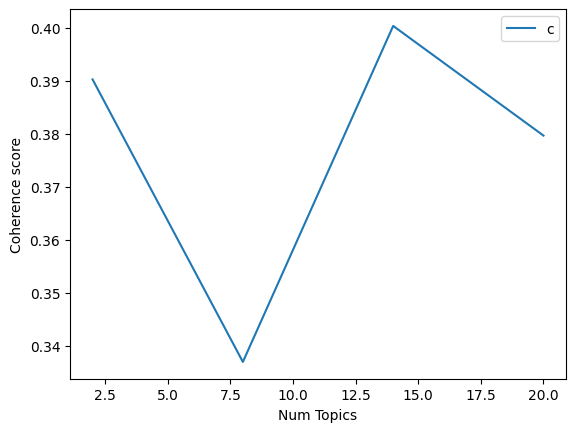

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_q1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_q1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 2  has Coherence Value of 0.247
Num Topics = 8  has Coherence Value of 0.399
Num Topics = 14  has Coherence Value of 0.405
Num Topics = 20  has Coherence Value of 0.375


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Second Quantile

### Model training

In [ ]:
# Create Dictionary
id2word_q2 = corpora.Dictionary(corpus_q2)

# Filter tokens that appear in less than 5 documents, but more than 0.5 documents  
id2word_q2.filter_extremes(5, 0.5)

# Term Document Frequency
corpus_q2_tdf = [id2word_q2.doc2bow(word) for word in corpus_q2]

# Let's start with 2 topics.
lda_model_q2 = models.LdaModel(corpus=corpus_q2_tdf, id2word=id2word_q2, num_topics=8, passes=10)
lda_model_q2.print_topics()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.075*"medication" + 0.050*"consent" + 0.044*"plan" + 0.043*"authorized" + 0.043*"representative" + 0.043*"patientlegally" + 0.041*"continue" + 0.041*"face" + 0.035*"side" + 0.031*"symptoms"'),
 (1,
  '0.122*"history" + 0.053*"status" + 0.046*"final" + 0.045*"range" + 0.044*"value" + 0.044*"ref" + 0.044*"datetime" + 0.042*"surgical" + 0.041*"family" + 0.039*"file"'),
 (2,
  '0.038*"ha" + 0.026*"patient" + 0.023*"sleep" + 0.023*"report" + 0.023*"reported" + 0.018*"good" + 0.015*"mood" + 0.012*"school" + 0.011*"day" + 0.011*"taking"'),
 (3,
  '0.028*"pt" + 0.015*"lab" + 0.014*"note" + 0.012*"service" + 0.012*"next" + 0.011*"see" + 0.010*"need" + 0.010*"completed" + 0.009*"contact" + 0.009*"medication"'),
 (4,
  '0.044*"clinic" + 0.043*"use" + 0.043*"week" + 0.032*"return" + 0.026*"substance" + 0.016*"med" + 0.013*"report" + 0.013*"risk" + 0.013*"drug" + 0.013*"current"'),
 (5,
  '0.038*"mother" + 0.034*"report" + 0.030*"ha" + 0.023*"wa" + 0.019*"school" + 0.018*"well" + 0.018*"ac

### Model evaluation

In [ ]:
# Visualize the topics
vis_q2 = pyLDAvis.gensim_models.prepare(lda_model_q2, corpus_q2_tdf, id2word_q2)
vis_q2

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.002924 -0.125953       1        1  14.517519
5      0.220222 -0.132363       2        1  13.800402
2      0.242103 -0.030806       3        1  12.897019
1      0.133419  0.420520       4        1  12.724170
0     -0.324280  0.040345       5        1  12.421521
3      0.040627 -0.162595       6        1  12.413568
6     -0.140480 -0.061005       7        1  11.149479
7     -0.168687  0.051857       8        1  10.076323, topic_info=            Term          Freq         Total Category  logprob  loglift
2        history   9035.000000   9035.000000  Default  30.0000  30.0000
39       patient   8428.000000   8428.000000  Default  29.0000  29.0000
38    medication  10173.000000  10173.000000  Default  28.0000  28.0000
49       consent   3639.000000   3639.000000  Default  27.0000  27.0000
102       status   4681.000000   4681.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
363  medications    774.240196   1613.186223   Topic8  -4.3281   1.5609
161      symptom    528.163793    852.585256   Topic8  -4.7106   1.8161
397         adhd    528.737486    878.765587   Topic8  -4.7095   1.7870
87        vitals    527.573701   1158.938332   Topic8  -4.7117   1.5080
48         visit    542.794790   2904.488281   Topic8  -4.6833   0.6177

[399 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
416       2  0.420266      able
416       6  0.578882      able
587       8  0.997622  abnormal
124       2  0.999081    active
125       1  0.548618  activity
...     ...       ...       ...
414       2  0.888245      year
414       3  0.110389      year
868       1  0.996826     years
237       5  0.998951       yes
214       2  0.995987        yo

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 2, 1, 4, 7, 8])

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_q2.log_perplexity(corpus_q2_tdf))

# Compute Coherence Score
# included two different measures of coherence, use the one that produces better results
coherence_model_lda_q2 = CoherenceModel(model=lda_model_q2, dictionary=id2word_q2, texts = corpus_q2, coherence='c_v')
# coherence_model_lda_q2 = CoherenceModel(model=lda_model_q2, dictionary=id2word_q2, corpus = corpus_q2_tdf, coherence='u_mass')
coherence_lda_q2 = coherence_model_lda_q2.get_coherence()
print('\nCoherence Score: ', coherence_lda_q2)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.42770800787063

Coherence Score:  0.3864893121790346


### Determine optimal number of topics

In [ ]:
from pandas.io.parsers.readers import TextParser
# Determine optimal number of topics
def compute_coherence_values_q2(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'Training model for num_topics= {num_topics}')
        model = models.LdaModel(corpus=corpus, id2word=id2word_q2, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Can take a long time to run
model_list_q2, coherence_values_q2 = compute_coherence_values_q2(dictionary=id2word_q2, corpus=corpus_q2_tdf, texts=corpus_q2, start=start, limit=limit, step=step)
print('Completed!')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training model for num_topics= 2
Training model for num_topics= 8
Training model for num_topics= 14
Training model for num_topics= 20
Completed!


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


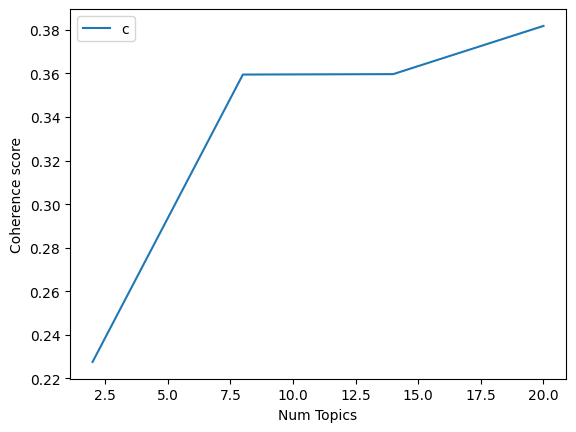

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_q2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_q2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 2  has Coherence Value of 0.228
Num Topics = 8  has Coherence Value of 0.36
Num Topics = 14  has Coherence Value of 0.36
Num Topics = 20  has Coherence Value of 0.382


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Third Quantile

### Model training

In [ ]:
# Create Dictionary
id2word_q3 = corpora.Dictionary(corpus_q3)

# Filter tokens that appear in less than 5 documents, but more than 0.5 documents  
id2word_q3.filter_extremes(5, 0.5)

# Term Document Frequency
corpus_q3_tdf = [id2word_q3.doc2bow(word) for word in corpus_q3]

# Let's start with 2 topics
lda_model_q3 = models.LdaModel(corpus=corpus_q3_tdf, id2word=id2word_q3, num_topics=8, passes=10)
lda_model_q3.print_topics()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.073*"clinic" + 0.068*"week" + 0.059*"return" + 0.043*"continue" + 0.031*"reported" + 0.027*"see" + 0.027*"tablet" + 0.025*"take" + 0.024*"safety" + 0.022*"mg"'),
 (1,
  '0.032*"weight" + 0.031*"medication" + 0.028*"recommended" + 0.026*"assessment" + 0.024*"refer" + 0.022*"health" + 0.018*"thought" + 0.018*"exercise" + 0.015*"behavior" + 0.015*"risk"'),
 (2,
  '0.088*"history" + 0.058*"status" + 0.051*"range" + 0.050*"final" + 0.050*"ref" + 0.049*"value" + 0.049*"datetime" + 0.033*"surgical" + 0.030*"family" + 0.025*"file"'),
 (3,
  '0.045*"care" + 0.045*"education" + 0.035*"pcp" + 0.031*"medical" + 0.029*"medication" + 0.029*"treatment" + 0.028*"abnormal" + 0.025*"referred" + 0.024*"diagnosis" + 0.021*"collaborative"'),
 (4,
  '0.066*"medication" + 0.063*"continue" + 0.051*"side" + 0.051*"labs" + 0.050*"effects" + 0.049*"vital" + 0.048*"symptoms" + 0.048*"signs" + 0.046*"monitoring" + 0.046*"target"'),
 (5,
  '0.050*"report" + 0.040*"ha" + 0.035*"pt" + 0.020*"drug" + 0.020*"

### Model evaluation

In [ ]:
# Visualize the topics
vis_q3 = pyLDAvis.gensim_models.prepare(lda_model_q3, corpus_q3_tdf, id2word_q3)
vis_q3

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.162484  0.162207       1        1  18.848852
2     -0.379809 -0.121871       2        1  16.661628
6      0.069292  0.180061       3        1  13.133174
3      0.088151  0.271287       4        1  12.272460
7      0.155388 -0.088915       5        1  10.466364
1     -0.065290 -0.064007       6        1  10.107825
0      0.110244 -0.213006       7        1   9.313792
4      0.184509 -0.125756       8        1   9.195905, topic_info=           Term          Freq         Total Category  logprob  loglift
55      history   7213.000000   7213.000000  Default  30.0000  30.0000
105  medication  10864.000000  10864.000000  Default  29.0000  29.0000
97     continue   4789.000000   4789.000000  Default  28.0000  28.0000
113      clinic   3320.000000   3320.000000  Default  27.0000  27.0000
108        side   4806.000000   4806.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
102     service    335.338445    714.185749   Topic8  -4.9012   1.6304
383        case    236.199253    400.070264   Topic8  -5.2517   1.8594
160       daily    273.198491   1655.821341   Topic8  -5.1062   0.5846
44    substance    256.295890   1628.095836   Topic8  -5.1700   0.5376
351          go    198.395664    605.469293   Topic8  -5.4261   1.2707

[373 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
787       5  0.998427      able
77        3  0.016259  abnormal
77        4  0.983099  abnormal
1177      1  0.998414       act
377       6  0.413797    active
...     ...       ...       ...
26        3  0.258806      work
14        1  0.997331   working
207       5  0.998700        wt
1121      2  0.998111     years
649       3  0.999160       yes

[419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 4, 8, 2, 1, 5])

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_q3.log_perplexity(corpus_q3_tdf))

# Compute Coherence Score
# included two different measures of coherence, use the one that produces better results
coherence_model_lda_q3 = CoherenceModel(model=lda_model_q3, dictionary=id2word_q3, texts = corpus_q3, coherence='c_v')
# coherence_model_lda_q3 = CoherenceModel(model=lda_model_q3, dictionary=id2word_q3, corpus = corpus_q3_tdf, coherence='u_mass')
coherence_lda_q3 = coherence_model_lda_q3.get_coherence()
print('\nCoherence Score: ', coherence_lda_q3)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.336229256469589

Coherence Score:  0.40349908129250733


### Determine optimal number of topics

In [ ]:
from pandas.io.parsers.readers import TextParser
# Determine optimal number of topics
def compute_coherence_values_q3(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'Training model for num_topics= {num_topics}')
        model = models.LdaModel(corpus=corpus, id2word=id2word_q3, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Can take a long time to run
model_list_q3, coherence_values_q3 = compute_coherence_values_q3(dictionary=id2word_q3, corpus=corpus_q3_tdf, texts=corpus_q3, start=start, limit=limit, step=step)
print('Completed!')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training model for num_topics= 2
Training model for num_topics= 8
Training model for num_topics= 14
Training model for num_topics= 20
Completed!


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


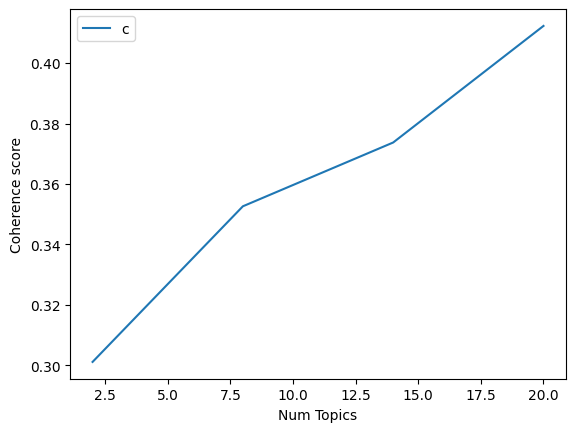

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_q3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_q3):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 2  has Coherence Value of 0.301
Num Topics = 8  has Coherence Value of 0.353
Num Topics = 14  has Coherence Value of 0.374
Num Topics = 20  has Coherence Value of 0.412


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
